# First  Try at making NN with mesh input (as a graph)

- Creating the dataset from mesh files and solver times (node based), log-transform of time available
- Creating the grapth neural network (two simple models) for regression

In [1]:
import sys
print(sys.executable)


c:\Users\aol053\.conda\envs\mytorch\python.exe


In [2]:
import os
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Dataset, Data
import meshio

In [42]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import contextlib # to suppress output

## Investigate the solving times DataFrame:

In [4]:
df = pd.read_csv("D:/ML4pmg/Data/solver_times.csv")
df.head()

,Mesh #,Combination #,KSP Type,PC Mass,PC Interface,Converged,Krylov Iters,Construction Time (s),Solve Time (s),Total Time (s),Tic Toc Time (s),Solver Label,Adjusted Time (s)
0,0,0,gmres,ilu,ilu,True,33.0,0.002313,0.002193,0.004506,0.151635,gmres + ilu + ilu,0.004506
1,0,1,gmres,lu,ilu,True,8.0,0.004776,0.000730,0.005507,0.165953,gmres + lu + ilu,0.005507
2,0,2,gmres,sor,ilu,True,81.0,0.002156,0.005257,0.007413,0.137075,gmres + sor + ilu,0.007413
3,0,3,gmres,jacobi,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + jacobi + ilu,1.784661
4,0,4,gmres,bjacobi,ilu,True,33.0,0.006477,0.008921,0.015398,0.171397,gmres + bjacobi + ilu,0.015398


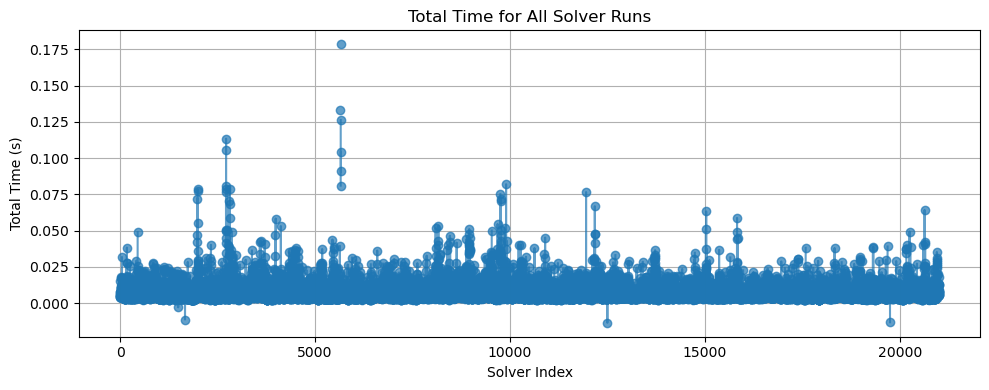

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(df["Total Time (s)"].values, marker='o', linestyle='-', alpha=0.7)
plt.xlabel("Solver Index")
plt.ylabel("Total Time (s)")
plt.title("Total Time for All Solver Runs")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
np.nanmax(df["Total Time (s)"].values)*10

1.784660816192627

In [7]:
# Filter rows with negative construction time
bad_rows = df[df["Construction Time (s)"] < 0]

# Display them
print(bad_rows)


       Mesh #  Combination # KSP Type PC Mass PC Interface  Converged  \
12494     594             20    tfqmr    gamg          ilu       True   

       Krylov Iters  Construction Time (s)  Solve Time (s)  Total Time (s)  \
12494          19.0              -0.014634        0.001041       -0.013593   

       Tic Toc Time (s)        Solver Label  Adjusted Time (s)  
12494           0.09518  tfqmr + gamg + ilu          -0.013593  


## Create the MeshSolverDataset object

In [43]:
class MeshSolverDataset(Dataset):
    def __init__(self, mesh_dir, csv_path, transform=None, pre_transform=None, log_transform=True):
        """
        mesh_dir: directory with .msh files (e.g., 'D:/ML4pmg/Data/')
        csv_path: CSV file with solver results (e.g., 'D:/ML4pmg/Data/solver_times.csv')
        """
        super().__init__(mesh_dir, transform, pre_transform)
        self.mesh_dir = mesh_dir
        self.csv = pd.read_csv(csv_path)
        
        # Group by mesh ID to prepare target vectors per mesh
        self.mesh_targets = self.csv.pivot_table(
            index='Mesh #',
            columns='Solver Label',
            values='Adjusted Time (s)'
        ).sort_index()

        if log_transform:
            self.mesh_targets = self.mesh_targets.applymap(lambda x: -np.log(abs(x) + 1e-6))
        else:
            self.mesh_targets = self.mesh_targets.applymap(lambda x: (abs(x)))
        # List of available mesh IDs
        self.mesh_ids = self.mesh_targets.index.tolist()

        # Solver labels (for reference)
        self.solver_labels = self.mesh_targets.columns.tolist()

    def len(self):
        return len(self.mesh_ids)

    def get(self, idx):
        """
        Load mesh, convert to PyG Data object, and attach solver time vector as y
        """
        mesh_id = self.mesh_ids[idx]
        mesh_filename = f"mesh2d_7fr_{mesh_id:03d}.msh"
        mesh_path = os.path.join(self.mesh_dir, mesh_filename)

        # Read mesh with meshio
        mesh = meshio.read(mesh_path)

        # Extract nodes (coordinates) and triangle elements
        coords = mesh.points.astype(np.float32)
        triangles = mesh.cells_dict.get("triangle")

        if triangles is None:
            raise ValueError(f"No triangle elements in {mesh_filename}")

        # PyG expects COO format edge_index: 2 x num_edges
        # For triangles, we make edges between each pair of triangle corners
        edge_index_list = []
        for tri in triangles:
            i, j, k = tri
            edge_index_list += [(i, j), (j, k), (k, i)]

        # Remove duplicates and convert to tensor
        edge_index = torch.tensor(list(set(edge_index_list)), dtype=torch.long).t().contiguous()

        # Features: here we use only coordinates as node features
        x = torch.tensor(coords, dtype=torch.float32)

        # Target: solver time vector for this mesh
        y_row = self.mesh_targets.loc[mesh_id].values.astype(np.float32)
        y = torch.tensor(y_row, dtype=torch.float32)

        # Build PyG data object
        data = Data(x=x, edge_index=edge_index, y=y)
        data.mesh_id = mesh_id  # optional: keep ID for reference
        return data


In [44]:
dataset = MeshSolverDataset(
    mesh_dir="D:/ML4pmg/Data/",
    csv_path="D:/ML4pmg/Data/solver_times.csv",
    log_transform=False  
)

print(f"Loaded {len(dataset)} graphs")
print(dataset[0])


Loaded 1000 graphs

Data(x=[387, 3], edge_index=[2, 2154], y=[21], mesh_id=0)


In [10]:
data = dataset[0]
print(data.y) 


tensor([0.0039, 0.0037, 0.0084, 0.0039, 0.0060, 0.0054, 0.0045, 0.0048, 0.0154,
        0.0076, 0.0045, 1.7847, 0.0055, 0.0074, 0.0043, 0.0058, 0.0078, 0.0040,
        0.0064, 0.0118, 0.0069])


## Visualize few samples in the dataset

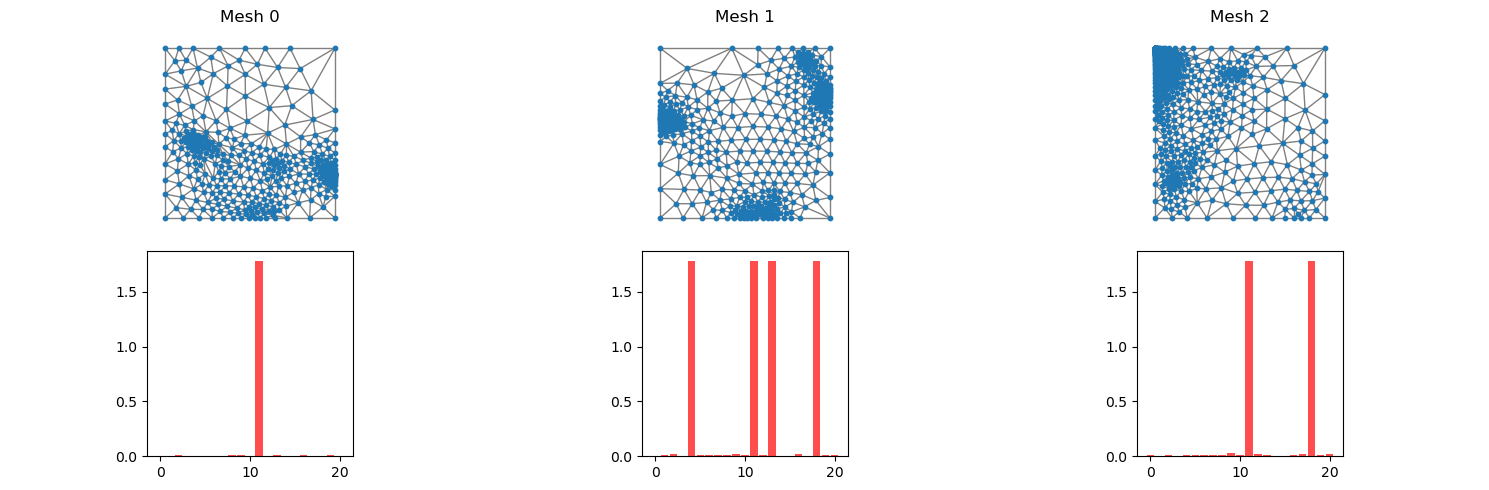

In [45]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))

for i in range(3):
    data = dataset[i]
    G = to_networkx(data, to_undirected=True)
    
    # Use node coordinates for layout
    pos = {j: (data.x[j][0].item(), data.x[j][1].item()) for j in range(data.num_nodes)}
    
    ax = axes[0,i]
    nx.draw(
        G, pos=pos, ax=ax, node_size=10, edge_color="gray"
    )
    ax.set_title(f"Mesh {data.mesh_id}")
    ax.axis("equal")
    ax.axis("off")

    ax = axes[1,i]
    ax.bar(range(len(data.y)),data.y.numpy(), color='red', alpha=0.7)
    ax.set_box_aspect(1) 

plt.tight_layout()
plt.show()

## Create the model

Import needed packages

In [46]:
# For building the neural network
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool

# For data splitting and loading
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch.utils.data import random_split


# For training
import torch.optim as optim

## First (Simple) Model

In [47]:
class MeshSolverTimeNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim,hidden_dim)
        self.lin1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        # Graph convolutions
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Global pooling to get graph-level feature
        x = global_mean_pool(x, batch)

        # Fully connected layers
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)  # Output: solver time vector
        #x = F.relu(x) # Possible make it positive
        return x


In [48]:
print("Node feature dim:", dataset[0].x.shape)
print("Target vector dim:", dataset[0].y.shape[0])



Node feature dim: torch.Size([387, 3])

Target vector dim: 21


In [49]:
gnn_model = MeshSolverTimeNet(
    input_dim = 3,
    hidden_dim = 64,
    output_dim = 21
)

print(gnn_model)

num_params = sum(p.numel() for p in gnn_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

MeshSolverTimeNet(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 64)
  (lin1): Linear(in_features=64, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=21, bias=True)
)
Number of trainable parameters: 9941


## Second (a bit more complex) Model

In [17]:

class GATNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=4):
        super(GATNet, self).__init__()
        
        self.conv1 = GATConv(input_dim, hidden_dim, heads=num_heads, dropout=0.2)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=0.2)
        self.conv3 = GATConv(hidden_dim, hidden_dim, heads=1, dropout=0.2)
        
        self.lin1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, x, edge_index, batch):
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = F.elu(self.conv3(x, edge_index))
        
        x = global_mean_pool(x, batch)
        
        x = self.dropout(F.relu(self.lin1(x)))
        x = self.lin2(x)
        #x = F.relu(x)
        return x


In [18]:
gnn_model = GATNet(
    input_dim=3,
    hidden_dim=64,
    output_dim=21
)

print(gnn_model)

num_params = sum(p.numel() for p in gnn_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

GATNet(
  (conv1): GATConv(3, 64, heads=4)
  (conv2): GATConv(256, 64, heads=1)
  (conv3): GATConv(64, 64, heads=1)
  (lin1): Linear(in_features=64, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=21, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Number of trainable parameters: 27925


Split data and make dataset for single batch training

In [58]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define split sizes
total_len = len(dataset)
train_len = int(0.8 * total_len)
test_len = total_len - train_len

train_dataset, test_dataset = random_split(dataset, [train_len, test_len])


batch_size = None  # Set to None for full batch, or specify a number for mini-batches
if batch_size is None:
    # Merge all training graphs into one big batch
    
    with contextlib.redirect_stdout(None):
        train_batch = Batch.from_data_list([train_dataset[i] for i in range(len(train_dataset))]);
        test_batch = Batch.from_data_list([test_dataset[i] for i in range(len(test_dataset))]);
else:
    # Create loaders with mini-batches
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    

In [51]:
for i in range(5):
    print(repr(train_dataset[i]))


Data(x=[543, 3], edge_index=[2, 3093], y=[21], mesh_id=542)

Data(x=[418, 3], edge_index=[2, 2388], y=[21], mesh_id=618)

Data(x=[275, 3], edge_index=[2, 1494], y=[21], mesh_id=816)

Data(x=[485, 3], edge_index=[2, 2715], y=[21], mesh_id=68)

Data(x=[1692, 3], edge_index=[2, 9924], y=[21], mesh_id=94)


In [52]:
gnn_model = MeshSolverTimeNet(
    input_dim = 3,
    hidden_dim = 64,
    output_dim = 21
)

print(gnn_model)

num_params = sum(p.numel() for p in gnn_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

MeshSolverTimeNet(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 64)
  (lin1): Linear(in_features=64, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=21, bias=True)
)
Number of trainable parameters: 9941


In [53]:
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(gnn_model.parameters(), lr=0.001)


This needs to be fixed, the 'batch.y.view(-1,21)' is hard-coded now for both, train and evaluate

In [54]:
# On whole dataset
def train_full_batch(model, batch, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(batch.x, batch.edge_index, batch.batch)
    loss = criterion(out, batch.y.view(-1, 21))
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_full_batch(model, batch, criterion):
    model.eval()
    with torch.no_grad():
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y.view(-1, 21))

    return loss.item()

#Batch training and evaluation functions
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y.view(-1, 21))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs  # scale by batch size
    return total_loss / len(loader.dataset)


def evaluate_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y.view(-1, 21))
            total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)


Lets make one forward pass to check!

In [55]:
data = dataset[0]
gnn_model.eval()  # set to evaluation mode
with torch.no_grad():
    batch_vector = torch.zeros(data.num_nodes, dtype=torch.long)  # all nodes belong to graph 0
    output = gnn_model(data.x, data.edge_index, batch_vector)
print("Output shape:", output.shape)  # should be (1, 21)
print("Output:", output)


Output shape: torch.Size([1, 21])
Output: tensor([[ 0.1432, -0.1235,  0.1520,  0.0542,  0.0090, -0.0780,  0.1330, -0.0656,
          0.0528,  0.0425, -0.0599,  0.0785,  0.0092, -0.0311, -0.1198,  0.0539,
         -0.1283, -0.0809,  0.0851, -0.0675,  0.1035]])


## Train the model

In [65]:
n_epochs = 30

if batch_size is not None:
    # Use mini-batch training
    for epoch in range(1, n_epochs + 1):
        train_loss = train_epoch(gnn_model, train_loader, optimizer, criterion)
        test_loss = evaluate_epoch(gnn_model, test_loader, criterion)
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
else:
    for epoch in range(1, n_epochs + 1):
        with contextlib.redirect_stdout(None):
            train_loss = train_full_batch(gnn_model, train_batch, optimizer, criterion)
            test_loss = evaluate_full_batch(gnn_model, test_batch, criterion)
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

Epoch 001 | Train Loss: 0.1066 | Test Loss: 0.1179
Epoch 002 | Train Loss: 0.1066 | Test Loss: 0.1178
Epoch 003 | Train Loss: 0.1066 | Test Loss: 0.1178
Epoch 004 | Train Loss: 0.1066 | Test Loss: 0.1178
Epoch 005 | Train Loss: 0.1065 | Test Loss: 0.1177
Epoch 006 | Train Loss: 0.1065 | Test Loss: 0.1177
Epoch 007 | Train Loss: 0.1065 | Test Loss: 0.1177
Epoch 008 | Train Loss: 0.1065 | Test Loss: 0.1176
Epoch 009 | Train Loss: 0.1065 | Test Loss: 0.1176
Epoch 010 | Train Loss: 0.1065 | Test Loss: 0.1176
Epoch 011 | Train Loss: 0.1065 | Test Loss: 0.1175
Epoch 012 | Train Loss: 0.1065 | Test Loss: 0.1175
Epoch 013 | Train Loss: 0.1065 | Test Loss: 0.1175
Epoch 014 | Train Loss: 0.1065 | Test Loss: 0.1175
Epoch 015 | Train Loss: 0.1065 | Test Loss: 0.1175
Epoch 016 | Train Loss: 0.1065 | Test Loss: 0.1174
Epoch 017 | Train Loss: 0.1065 | Test Loss: 0.1174
Epoch 018 | Train Loss: 0.1065 | Test Loss: 0.1174
Epoch 019 | Train Loss: 0.1065 | Test Loss: 0.1174
Epoch 020 | Train Loss: 0.1064 

In [64]:
from tqdm import tqdm

n_epochs = 5
for epoch in tqdm(range(1, n_epochs + 1)):
    with contextlib.redirect_stdout(None):
        train_loss = train_epoch(gnn_model, train_loader, optimizer, criterion);
        test_loss = evaluate_epoch(gnn_model, test_loader, criterion);
    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

  0%|          | 0/5 [00:04<?, ?it/s]


KeyboardInterrupt: 

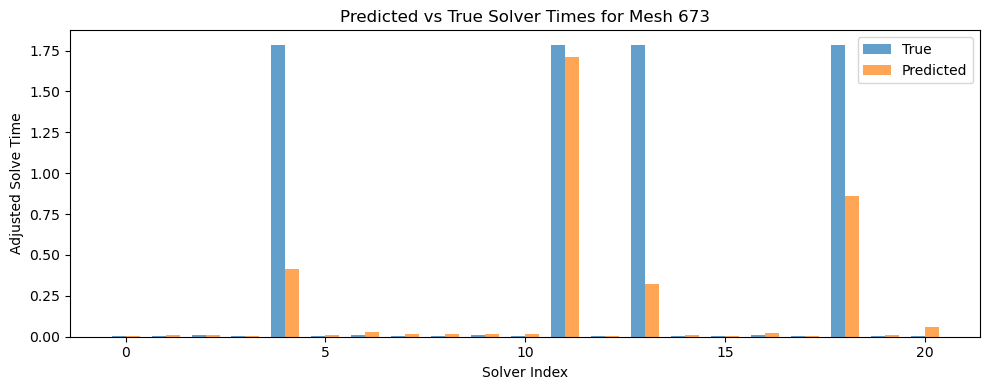

In [71]:
# Select one sample from test_dataset
data = test_dataset[0]

# Prepare batch vector (all zeros for a single graph)
batch_vector = torch.zeros(data.num_nodes, dtype=torch.long)

# Model to eval mode
gnn_model.eval()
with torch.no_grad():
    y_pred = gnn_model(data.x, data.edge_index, batch_vector).squeeze()
    y_true = data.y

# Convert to NumPy for plotting
y_pred = y_pred.numpy()
y_true = y_true.numpy()

# Plot
plt.figure(figsize=(10, 4))
width = 0.35
indices = range(len(y_true))

plt.bar([i - width/2 for i in indices], y_true, width=width, label="True", alpha=0.7)
plt.bar([i + width/2 for i in indices], y_pred, width=width, label="Predicted", alpha=0.7)

plt.xlabel("Solver Index")
plt.ylabel("Adjusted Solve Time")
plt.title(f"Predicted vs True Solver Times for Mesh {data.mesh_id}")
plt.legend()
plt.tight_layout()
plt.show()


In [67]:
print("Predicted minimum solver index:", np.argmin(y_pred))
print("True minimum solver index:", np.argmin(y_true))

Predicted minimum solver index: 3
True minimum solver index: 17


In [88]:
print("Predicted minimum solver index:", np.argmin(np.exp(-y_pred)))
print("True minimum solver index:", np.argmin(np.exp(-y_true)))

Predicted minimum solver index: 11
True minimum solver index: 11


In [70]:
print(y_true)
print(y_pred)


[0.00414658 0.0039134  0.00789022 0.00572157 0.01464844 0.00512028
 0.00470304 0.00505376 0.00453448 0.00755548 0.00489807 1.7846608
 0.00508142 0.0063405  0.00516534 0.00384736 0.0079205  0.00383496
 1.7846608  0.005018   0.00448608]
[7.3245913e-04 1.3193622e-02 7.5121522e-03 5.9506670e-04 4.3378392e-01
 1.1079479e-02 2.2407658e-02 2.2831619e-02 2.0302784e-02 1.8844537e-02
 2.5959060e-02 1.8084005e+00 6.7919958e-03 3.3840844e-01 1.3899416e-02
 1.9942783e-03 2.8448775e-02 8.3434694e-03 9.0571773e-01 1.1625495e-02
 5.4069355e-02]


The model results could be negative, we need to fix that! Job for tomorrow!!